In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv("../ficheros/diamons_enconding.csv", index_col = 0)
df.reset_index(drop= True, inplace= True) 
df.head()

,carat,depth,table,price,x,y,z,cut_map,color_map,clarity_map
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4,5,1
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3,5,2
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,5,4
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3,1,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,1


En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

*   Ajustar el modelo a un Decision Tree
*   Extraer las métricas
*   Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [3]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("price", axis = 1)
y = df["price"]

In [4]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lineal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [6]:
# Calculamos cual será nuestro max_features. En nuestro caso será 3
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [7]:
# Ahora calculamos el max depth, que será de 34 para nuestro dataset
print(arbol.tree_.max_depth)

34


In [8]:
# Hacemos las predicciones sobre x_test y x_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [9]:
# Función para que nos devuelva las métricas de nuestros datos en forma de dataframe
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):

    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [10]:
# Pasamos la función para ver las métricas y poder ver qué tal se ajusta 
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,267.159319,241786.789730,491.718202,0.968175,test,Decission Tree I
1,0.372776,42.506991,6.519739,0.999994,train,Decission Tree I


De momento vamos bien, pero tenemos un poco de overfitting y queremos ajustar un poco más los valores del test

In [11]:
# Definicimos los hiperparámetro con los que queremos probar para el GridSearch
param = {"max_depth": [28,29,30], 
        "max_features": [1,2,3,4],
        "min_samples_split": [100, 500],
        "min_samples_leaf": [100,500]} 

In [12]:
# Iniciamos el modelo con GridSearch
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error")

In [13]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [28, 29, 30],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [100, 500],
                         'min_samples_split': [100, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [14]:
# Le pedimos que nos devuelva cual ha sido el mejor modelo
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=28, max_features=4, min_samples_leaf=100,
                      min_samples_split=100)

In [15]:
# Volvemos a calcular las métricas
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [16]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,344.228556,370500.891199,608.687844,0.951233,test,Decision tree II
1,338.589162,353677.770194,594.708139,0.953762,train,Decision tree II


Ahora hay menos diferencia entre el train y el test y tenemos un buen valor del R2, pero vamos a volver a hacer otra prueba a ver si mejoramos el RMSE

In [17]:
# Definicimos los hiperparámetro con los que queremos probar para el GridSearch
param2 = {"min_samples_split": [100, 500, 1000],
        "min_samples_leaf": [100,500, 1000]} 

In [18]:
# Iniciamos el modelo con GridSearch
gs2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param2, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error")

In [19]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_leaf': [100, 500, 1000],
                         'min_samples_split': [100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [20]:
# Le pedimos que nos devuelva cual ha sido el mejor modelo
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeRegressor(min_samples_leaf=100, min_samples_split=100)

In [21]:
# Volvemos a calcular las métricas
y_pred_test_dt3 = mejor_modelo2.predict(x_test)
y_pred_train_dt3 = mejor_modelo2.predict(x_train)

In [22]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,289.775443,252865.323427,502.857160,0.966717,test,Decision tree III
1,282.196022,235744.622123,485.535397,0.969180,train,Decision tree III


In [23]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2, dt_results3], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,267.159319,241786.789730,491.718202,0.968175,test,Decission Tree I
1,0.372776,42.506991,6.519739,0.999994,train,Decission Tree I
0,344.228556,370500.891199,608.687844,0.951233,test,Decision tree II
1,338.589162,353677.770194,594.708139,0.953762,train,Decision tree II
0,289.775443,252865.323427,502.857160,0.966717,test,Decision tree III
1,282.196022,235744.622123,485.535397,0.969180,train,Decision tree III


Vamos a hacer otra prueba más ajustando los hiperparámetros de nuevo

In [24]:
param3 = {"max_depth": [32,33,34], 
        "max_features": [1,2,3,4],
        "min_samples_split": [50, 100, 500],
        "min_samples_leaf": [50, 100,500]} 

In [25]:
# Iniciamos el modelo con GridSearch
gs3 = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param3, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error")

In [26]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs3.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [32, 33, 34],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [50, 100, 500],
                         'min_samples_split': [50, 100, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [27]:
# Le pedimos que nos devuelva cual ha sido el mejor modelo
mejor_modelo3 = gs3.best_estimator_
mejor_modelo3

DecisionTreeRegressor(max_depth=34, max_features=4, min_samples_leaf=50,
                      min_samples_split=100)

In [28]:
# Volvemos a calcular las métricas
y_pred_test_dt4 = mejor_modelo3.predict(x_test)
y_pred_train_dt4 = mejor_modelo3.predict(x_train)

In [29]:
dt_results4 = metricas(y_test, y_train, y_pred_test_dt4, y_pred_train_dt4, "Decision tree IV")
dt_results4

,MAE,MSE,RMSE,R2,set,modelo
0,305.922207,281393.411240,530.465278,0.962962,test,Decision tree IV
1,289.919713,248256.639846,498.253590,0.967544,train,Decision tree IV


In [30]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2, dt_results3, dt_results4], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,267.159319,241786.789730,491.718202,0.968175,test,Decission Tree I
1,0.372776,42.506991,6.519739,0.999994,train,Decission Tree I
0,344.228556,370500.891199,608.687844,0.951233,test,Decision tree II
1,338.589162,353677.770194,594.708139,0.953762,train,Decision tree II
0,289.775443,252865.323427,502.857160,0.966717,test,Decision tree III
1,282.196022,235744.622123,485.535397,0.969180,train,Decision tree III
0,305.922207,281393.411240,530.465278,0.962962,test,Decision tree IV
1,289.919713,248256.639846,498.253590,0.967544,train,Decision tree IV


Según los resultados obtenidos, tenemos buenos resultados en general, pero lo que más nos gusta es el Decision Tree III, porque tenemos un R2 bueno y no hay mucha diferencia entre los RMSE del train y del test. Son resultados más estables

In [31]:
# Cargamos el csv con los resultados de la regresión lineal
df_reg_lineal= pd.read_csv("../ficheros/resultados_diamond.csv", index_col = 0)
df_reg_lineal

,MAE,MSE,RMSE,R2,set,modelo
0,590.914063,713235.499130,844.532711,0.906120,test,Linear Regresion
1,592.658127,722504.482639,850.002637,0.905544,train,LinearRegression


In [32]:
# Unimos todos los resultados
df_resultados = pd.concat([df_reg_lineal, df_decision_results], axis = 0)
df_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,590.914063,713235.499130,844.532711,0.906120,test,Linear Regresion
1,592.658127,722504.482639,850.002637,0.905544,train,LinearRegression
0,267.159319,241786.789730,491.718202,0.968175,test,Decission Tree I
1,0.372776,42.506991,6.519739,0.999994,train,Decission Tree I
0,344.228556,370500.891199,608.687844,0.951233,test,Decision tree II
1,338.589162,353677.770194,594.708139,0.953762,train,Decision tree II
0,289.775443,252865.323427,502.857160,0.966717,test,Decision tree III
1,282.196022,235744.622123,485.535397,0.969180,train,Decision tree III
0,305.922207,281393.411240,530.465278,0.962962,test,Decision tree IV
1,289.919713,248256.639846,498.253590,0.967544,train,Decision tree IV


In [33]:
df_resultados.to_csv("../ficheros/resultados_diamons_DT.csv")

In [34]:
# vamos a crearnos un dataframe con las variables más importantes
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,y,0.814489
8,clarity_map,0.072294
0,carat,0.068987
7,color_map,0.030772
3,x,0.012433
6,cut_map,0.000630
5,z,0.000229
2,table,0.000154
1,depth,0.000012


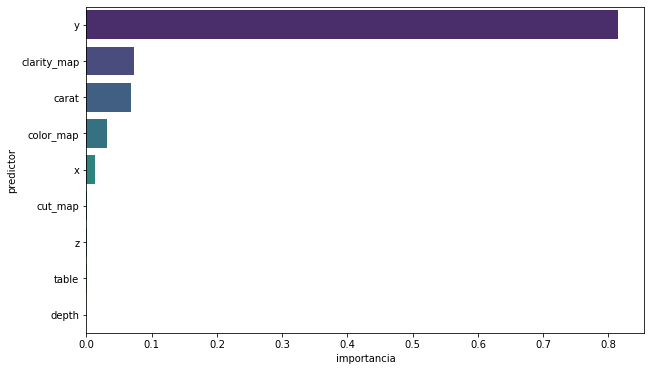

In [35]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

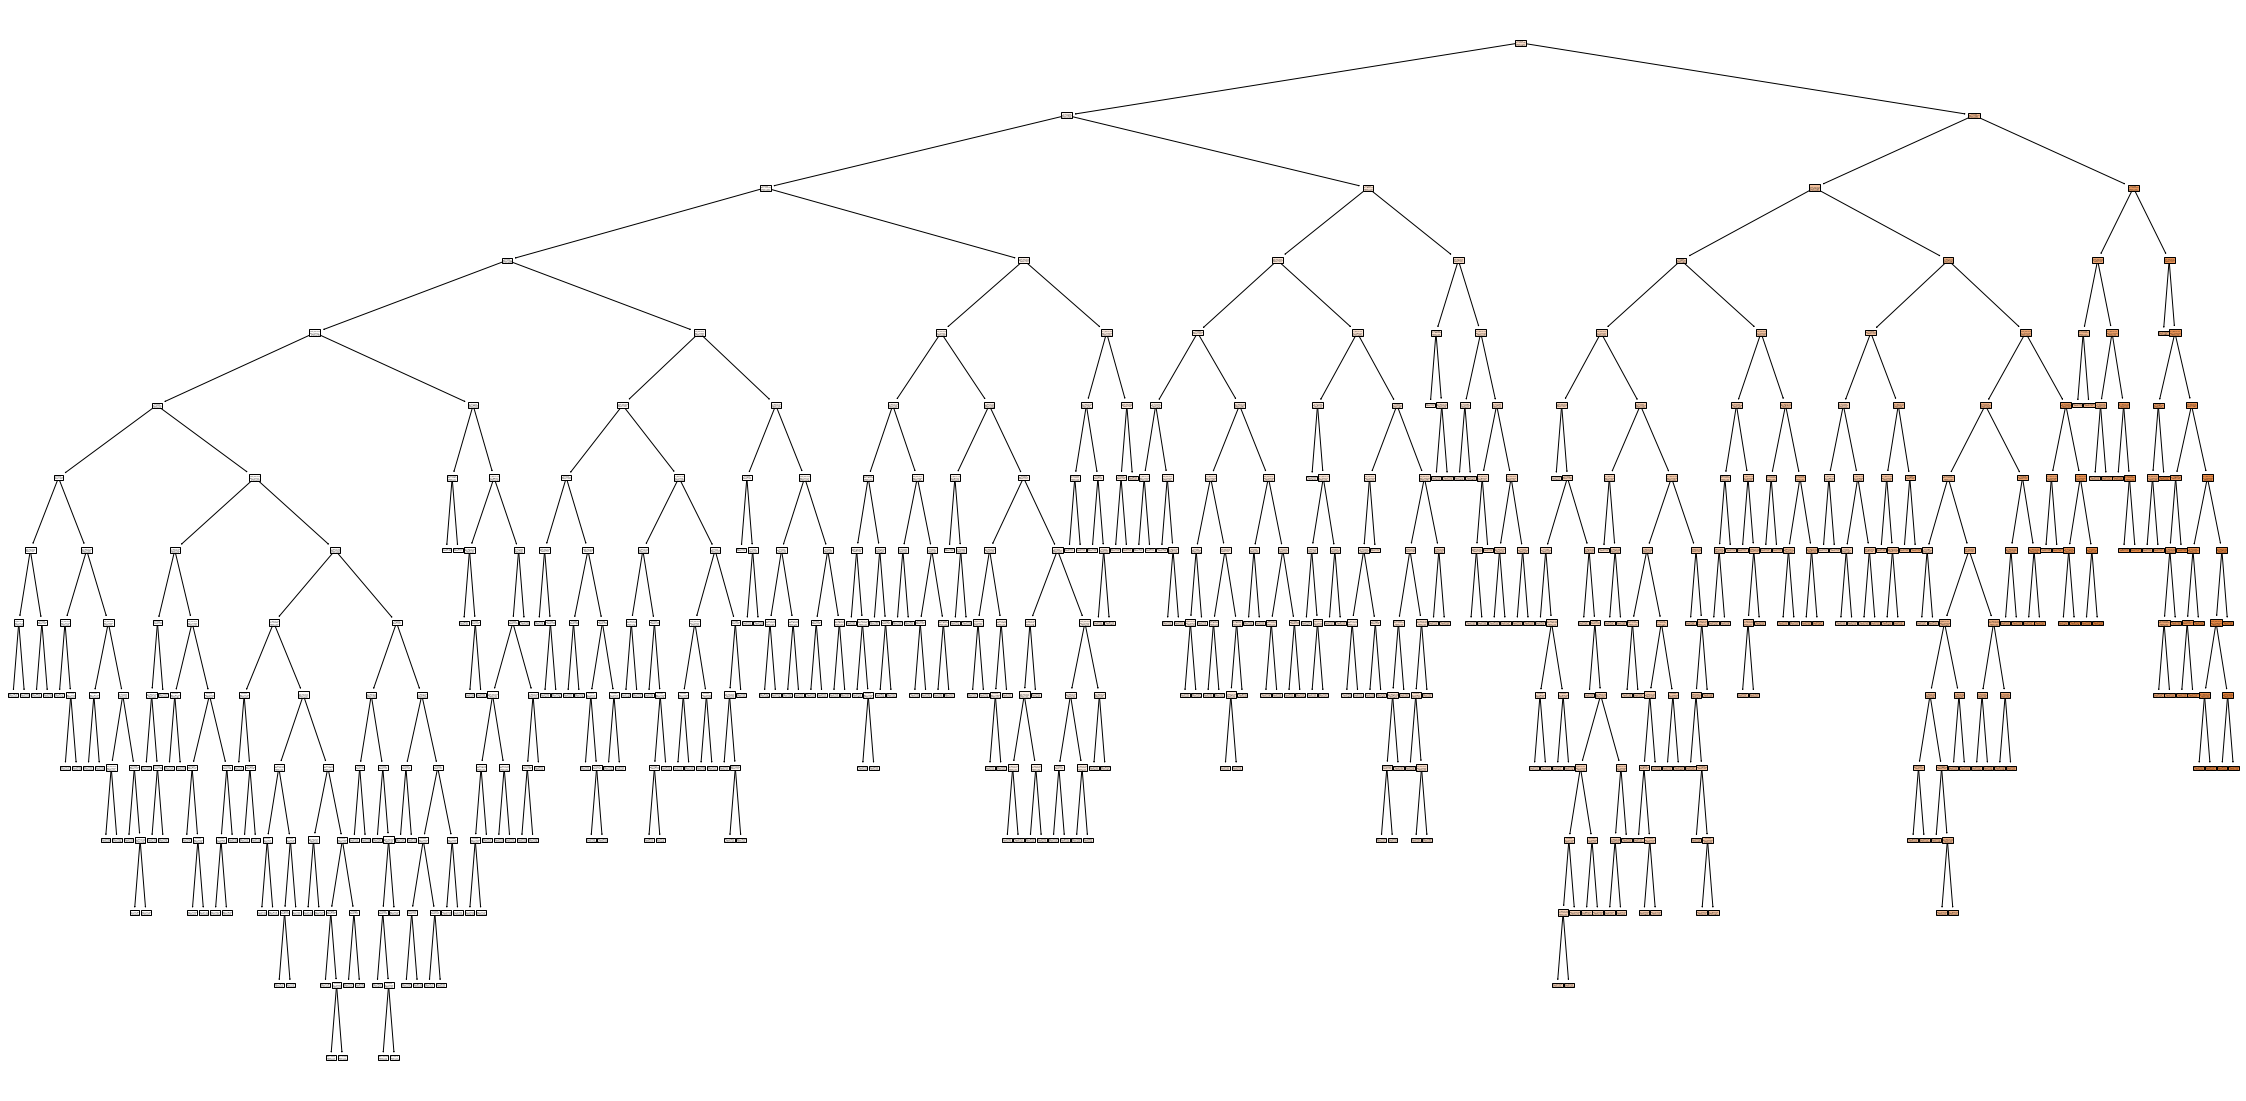

In [36]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo2, feature_names=x_train.columns, filled=True);

Nuestro arbol visualmente no es muy legible